<img src="header.png" align="left"/>

# Exercise Image classification with augmentation (10 points)

The goal of this example is to explain the organization, import and preparation of image data for classification including augmentation of the images. The following steps are performed:

- Dynamic loading and unpacking of image data from an external source.
- Review of the organization on the file system
- Loading of the data
- Transformations
- Augmentation
- Training
- Analysis
- Enhancement

The dataset used is called caltech101[3] with 101 classes and 40 to 800 images per class. The images have 200 - 300 pixel resolution in color.

Sources for the examples and data:


- [1] [https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/](https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/)
- [2] [https://github.com/bhavul/Caltech-101-Object-Classification](https://github.com/bhavul/Caltech-101-Object-Classification)
- [3] [http://www.vision.caltech.edu/Image_Datasets/Caltech101/](http://www.vision.caltech.edu/Image_Datasets/Caltech101/)


**NOTE**

Document your results by simply adding a markdown cell or a python cell (as comment) and writing your statements into this cell. For some tasks the result cell is already available.


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ditomax/mlexercises/blob/master/08%20Exercise%20Image%20classification%20with%20augmentation.ipynb)


In [40]:
#
# Prepare colab
#
COLAB=False
try:
    %tensorflow_version 2.x
    print("running on google colab")
    COLAB=True
    os.makedirs('data/caltech101',exist_ok=True)    
    os.makedirs('results',exist_ok=True)    
except:
    print("not running on google colab")


#
# Turn off errors and warnings (does not work sometimes)
#
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=Warning)
simplefilter(action='ignore', category=RuntimeWarning)



#
# Import of modules
#
import os
import logging
import tarfile
import operator
import random
from urllib.request import urlretrieve
from PIL import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


#
# Tensorflow and Keras
#
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Input, Dropout, Activation, Dense, MaxPooling2D, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adadelta
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#
# GPU Support
#
tflogger = tf.get_logger()
tflogger.setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR )
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print('using GPU support')


#
# Sizes of plots
#
plt.rcParams['figure.figsize'] = [16, 9]


#
# Versions
#
print('working on keras version {} on tensorflow {} using sklearn {}'.format ( tf.keras.__version__, tf.version.VERSION, sklearn.__version__ ) )

not running on google colab
working on keras version 2.4.0 on tensorflow 2.4.1 using sklearn 0.24.2


# Support functions for loading of data 

In [3]:
urlDataSource = 'http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz'
localExtractionFolder = 'data/caltech101'
localDataArchive = 'data/caltech101/caltech101.tar.gz'

In [4]:
#
# Load data from URL
#
def download_dataset(url,dataset_file_path):
    if os.path.exists(localDataArchive):
        print("archive already downloaded.")
    else:
        print("started loading archive from url {}".format(url))
        filename, headers = urlretrieve(url, dataset_file_path)
        print("finished loading archive from url {} with filename {}".format(url,filename))

#
# Extract images from archive
#       
def extract_dataset(dataset_file_path, extraction_directory):
    if (not os.path.exists(extraction_directory)):
        os.makedirs(extraction_directory)
    if (dataset_file_path.endswith("tar.gz") or dataset_file_path.endswith(".tgz")):
        tar = tarfile.open(dataset_file_path, "r:gz")
        tar.extractall(path=extraction_directory)
        tar.close()
    elif (dataset_file_path.endswith("tar")):
        tar = tarfile.open(dataset_file_path, "r:")
        tar.extractall(path=extraction_directory)
        tar.close()
    print("extraction of dataset from {} to {} done.".format(dataset_file_path,extraction_directory) )


# Load image data

In [5]:
#
# Run loading functions
#
download_dataset(urlDataSource,localDataArchive)

archive already downloaded.


In [6]:
#
# Extract files
#
extract_dataset(localDataArchive,localExtractionFolder)

extraction of dataset from data/caltech101/caltech101.tar.gz to data/caltech101 done.


# Organisation of image data on a file system


- [Brownlee](https://machinelearningmastery.com/how-to-load-large-datasets-from-directories-for-deep-learning-with-keras/) 
- [Sarkar](https://towardsdatascience.com/a-single-function-to-streamline-image-classification-with-keras-bd04f5cfe6df)



<div class="alert alert-block alert-info">

## Task

Read both of the above documents and describe the organization of image data in the file system as it is shown in one of the two linked documents (2 points).
</div>


# Prepare training data

In [25]:
#
# Get images from category folder 
#
def get_images(object_category, data_directory):
    if (not os.path.exists(data_directory)):
        print("data directory not found.")
        return
    obj_category_dir = os.path.join(os.path.join(data_directory,"101_ObjectCategories"),object_category)
    images = [os.path.join(obj_category_dir,img) for img in os.listdir(obj_category_dir)]
    return images


#
# Get categories
#
def return_categories(data_directory):
    folder = os.path.join(data_directory,"101_ObjectCategories")
    categories=[d for d in os.listdir(folder) if os.path.isdir(os.path.join(folder,d))]
    return categories

#
# Crop to square whitout cutting
#
def expand2square(pil_img, background_color):
    width, height = pil_img.size
    if width == height:
        return pil_img
    elif width > height:
        result = Image.new(pil_img.mode, (width, width), background_color)
        result.paste(pil_img, (0, (width - height) // 2))
        return result
    else:
        result = Image.new(pil_img.mode, (height, height), background_color)
        result.paste(pil_img, ((height - width) // 2, 0))
        return result


#
# Read image into memory
#
def read_image(image_path):
    im = Image.open(image_path).convert("RGB")
    im = expand2square(im, (0, 0, 0) )
    im = im.resize( (200,200) )
    return np.array(im).astype(np.float32)


#
# Loading images into memory
#
def create_training_data(data_directory,fraction):
    
    i = 0
    X = []
    Y = []
    
    print("started to read dataset from {}.".format(data_directory) )
    
    for category in return_categories(data_directory):
        
        if category == 'BACKGROUND_Google':
            continue
        
        print(".",end='')
        
        for image in get_images(category, data_directory):
            if not image.endswith('.jpg'):
                continue
                
            if random.uniform(0, 1) > fraction:
                continue
                
            X.insert(i, read_image(image) )
            Y.insert(i, category )
            i += 1
            
    print(".")
    print("finished reading dataset.")
    X = np.array(X)
    return X,Y

In [26]:
#
# Load training data into memory. Collect only a random sample of 70%. Does not care about distribution of classes.
#
X_raw, Y_raw = create_training_data(localExtractionFolder,fraction=0.7)

started to read dataset from data/caltech101.
......................................................................................................
finished reading dataset.


In [27]:
#
# Check shapes of data
#
print('X shape {}, Y len {}'.format(X_raw.shape,len(Y_raw)))

X shape (6050, 200, 200, 3), Y len 6050


In [28]:
#
# Transformation of labels in one-hot encoding
#
label_encoder = LabelEncoder()
Y_integer_encoded = label_encoder.fit_transform(Y_raw)
Y_one_hot = to_categorical(Y_integer_encoded)

In [29]:
Y_integer_encoded

array([ 1,  1,  1, ..., 65, 65, 65])

In [30]:
Y_one_hot.shape

(6050, 101)

In [31]:
#
# Scale image data
#

X_normalized = ( X_raw / 256.0 ) + 0.001
del X_raw

<div class="alert alert-block alert-info">

## Task

Explain why we do a ```del X_raw``` here. (2 points).
</div>

In [32]:
#
# Split data into training and validation sets
#
X_train, X_validation, Y_train, Y_validation = train_test_split(X_normalized, Y_one_hot, test_size=0.25, random_state=42)
del X_normalized


#
# values are now in X_train, X_validation, Y_train, Y_validation, label_encoder, data_directory
#

# Check the data

In [33]:
#
# Shape of final data
#
print('train: X=%s, y=%s' % (X_train.shape, Y_train.shape))
print('test: X=%s, y=%s' % (X_validation.shape, Y_validation.shape))

train: X=(4537, 200, 200, 3), y=(4537, 101)
test: X=(1513, 200, 200, 3), y=(1513, 101)


In [34]:
#
# Check the pixel values
#
np.amax(X_train[0])


0.99709374

In [35]:
np.amin(X_train[0])        

0.001

In [36]:
np.mean(X_train[0])

0.28723463

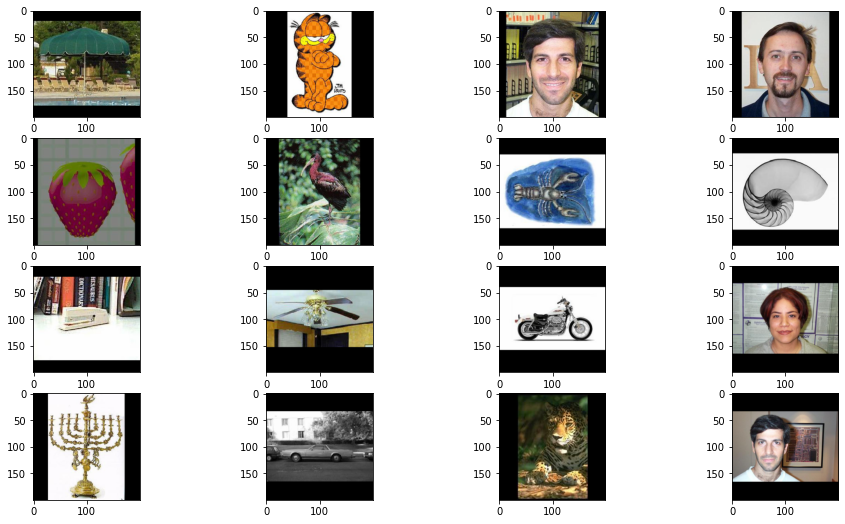

In [37]:
#
# Plot some images
#
_, axarr = plt.subplots(4,4)
for row in range(4):
    for column in range(4):
        axarr[row,column].imshow(X_train[row*4+column])        
plt.show()

In [41]:
#
# Check distribution of classes
#
df = pd.DataFrame(Y_integer_encoded,columns=['class'])
counts= df.groupby('class').size()
counts
#np.histogram(Y_integer_encoded, bins=101)

class
0      318
1      310
2      139
3      568
4       36
      ... 
96      42
97      25
98      32
99      28
100     42
Length: 101, dtype: int64

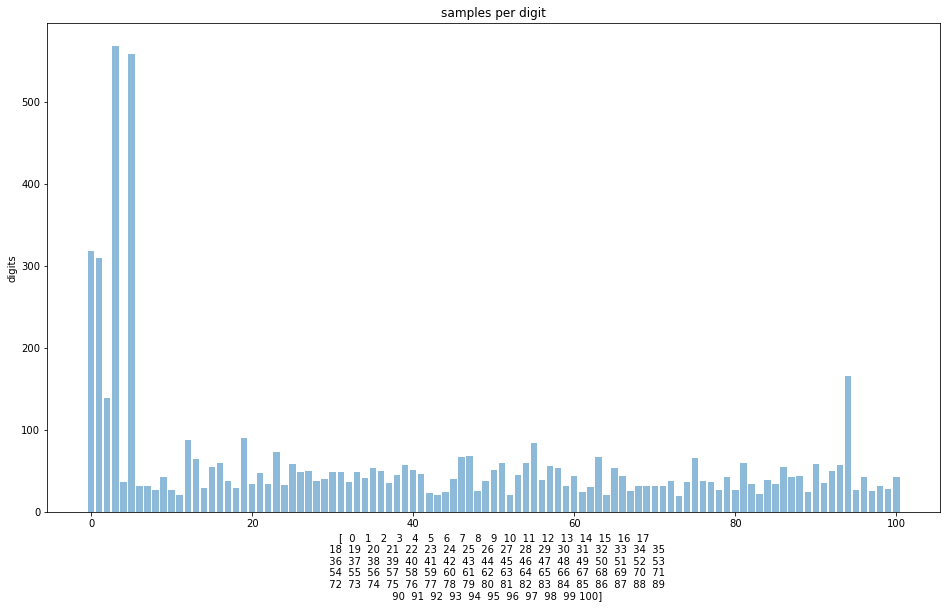

In [42]:
class_pos = np.arange(101)
plt.bar(class_pos, counts, align='center', alpha=0.5)
plt.xlabel(class_pos)
plt.ylabel('digits')
plt.title('samples per digit')
plt.show()

<div class="alert alert-block alert-info">

## Task

The current distribution of classes is not balanced. Research in the internet, what we could do to improve the distribution of classes. Write down and describe two possible solutions (2 points).
</div>

# Build a model

In [47]:
#
# Erzeugen eines einfache Modelles
#
def createModel():
    model = Sequential()
    model.add(Conv2D(16, (3,3), activation='relu', input_shape=(200,200,3)))
    model.add(Conv2D(32, (3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=2, strides=2))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(Conv2D(128, (3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=2, strides=2))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(101, activation='softmax'))
    return model

In [48]:
#
# Compile und Training des Modelles
#
model_cnn = createModel()
model_cnn.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

In [49]:
#
# Callbacks steuern das Speichern von Checkpoints und eine Überwachung gegen Overfitting.
#
callbacks = [ EarlyStopping(monitor='val_loss', patience=4, verbose=1, mode='auto')]

<div class="alert alert-block alert-info">

## Task

Run the training and try to find out how much memory the training is using. (1 point).

**Hint**: look for the memory usage of the python process.

</div>

In [50]:
history = model_cnn.fit(X_train, Y_train, batch_size=16, epochs=6, verbose=1, validation_data=(X_validation,Y_validation), callbacks=callbacks)

2022-03-24 11:39:49.976666: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2177760000 exceeds 10% of free system memory.


Epoch 1/6
284/284 [==============================] - 256s 900ms/step - loss: 4.1882 - accuracy: 0.2317 - val_loss: 2.6546 - val_accuracy: 0.4197
Epoch 2/6
284/284 [==============================] - 258s 909ms/step - loss: 2.0873 - accuracy: 0.5123 - val_loss: 2.2862 - val_accuracy: 0.4970
Epoch 3/6
284/284 [==============================] - 257s 904ms/step - loss: 0.7057 - accuracy: 0.8201 - val_loss: 3.3577 - val_accuracy: 0.4792
Epoch 4/6
284/284 [==============================] - 256s 902ms/step - loss: 0.1667 - accuracy: 0.9570 - val_loss: 4.0145 - val_accuracy: 0.4739
Epoch 5/6
284/284 [==============================] - 257s 904ms/step - loss: 0.0884 - accuracy: 0.9763 - val_loss: 5.0235 - val_accuracy: 0.4673
Epoch 6/6
284/284 [==============================] - 257s 904ms/step - loss: 0.0518 - accuracy: 0.9856 - val_loss: 4.6394 - val_accuracy: 0.4772
Epoch 00006: early stopping


In [51]:
#
# Evaluierung des Modelles
#
_, acc = model_cnn.evaluate(X_validation, Y_validation, verbose=0)
print('accuracy {:.3f} '.format(acc) )

accuracy 0.477 


In [52]:
#
# Ausgabe des Trainingsverlaufes
#
def summarize_diagnostics(history,modelname):
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='lightblue', label='test')
    plt.subplot(212)
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], color='green', label='train')
    plt.plot(history.history['val_accuracy'], color='lightgreen', label='test')
    plt.subplots_adjust(hspace=0.5)
    plt.savefig( 'results/' + modelname + '_plot.png')
    plt.show()
    plt.close()

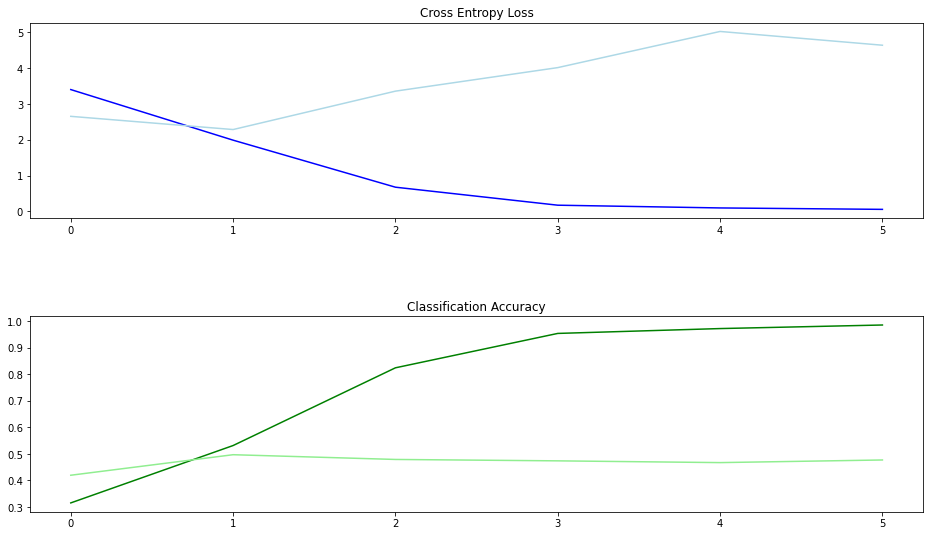

In [53]:
summarize_diagnostics(history,'05_model_cnn')

# Optimization using augmentation

Augmentation extends the training dataset with artificially generated images. This makes a model more robust and does not refer to individual pixels. Methods of augmentation for images are:

- Change width and height of image content (width_shift_range, height_shift_range).
- mirroring (flip)
- Rotation (rotation_range)
- Zooming (zoom_range)
- Brightness (brightness_range)
- Distortion (shear_range)

Adding noise cannot be set directly in Keras using the [ImageDataGenerator](https://keras.io/preprocessing/image/). However, this is approximately simulated by using dropout.


<img src="info.png" align="left"/> 

<div class="alert alert-block alert-info">

## Task

Experiment with the augmentation settings of the image generator to increase the accuracy by at least 5%. (2 point).

</div>

In [55]:
#
# Create generator for image loading
#
datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True, rotation_range=10, zoom_range=0.2 )
# prepare iterator
it_train = datagen.flow(X_train, Y_train, batch_size=16)

In [56]:
#
# Training
#
steps = int(X_train.shape[0] / 16)

In [57]:
model_cnn = createModel()
model_cnn.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

In [58]:
history = model_cnn.fit(it_train, steps_per_epoch=steps, epochs=12, validation_data=(X_validation,Y_validation), verbose=1, callbacks=callbacks)

Epoch 1/12
283/283 [==============================] - 256s 902ms/step - loss: 5.8002 - accuracy: 0.1708 - val_loss: 3.3783 - val_accuracy: 0.2868
Epoch 2/12
283/283 [==============================] - 254s 897ms/step - loss: 3.4406 - accuracy: 0.2769 - val_loss: 3.0705 - val_accuracy: 0.3173
Epoch 3/12
283/283 [==============================] - 255s 900ms/step - loss: 3.2137 - accuracy: 0.2996 - val_loss: 2.9743 - val_accuracy: 0.3344
Epoch 4/12
283/283 [==============================] - 255s 900ms/step - loss: 3.0301 - accuracy: 0.3290 - val_loss: 2.8341 - val_accuracy: 0.3761
Epoch 5/12
283/283 [==============================] - 255s 900ms/step - loss: 2.8673 - accuracy: 0.3570 - val_loss: 2.7091 - val_accuracy: 0.3906
Epoch 6/12
283/283 [==============================] - 255s 901ms/step - loss: 2.7239 - accuracy: 0.3782 - val_loss: 2.5571 - val_accuracy: 0.4382
Epoch 7/12
283/283 [==============================] - 255s 902ms/step - loss: 2.5773 - accuracy: 0.3980 - val_loss: 2.4896 -

In [59]:
#
# Evaluierung
#
_, acc = model_cnn.evaluate(X_validation, Y_validation, verbose=0)
print('accuracy {:.3f} '.format(acc) )

accuracy 0.557 


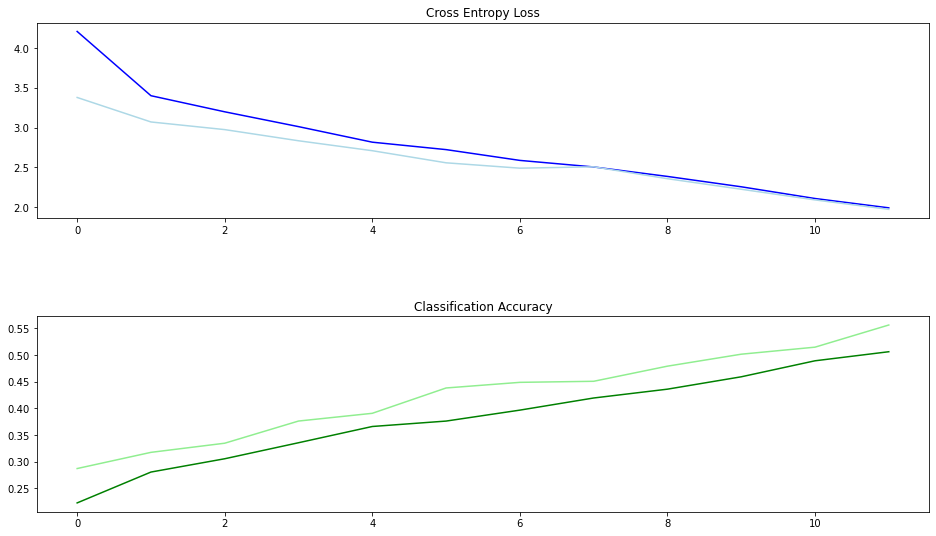

In [60]:
summarize_diagnostics(history,'08_model_cnn_aug')

# Test your model on a new image

In [91]:
#
# Prepare image (reusing import function defined above)
#
image_data_1 = np.array(read_image('data/test_image_1.png')) / 255.0
image_data_2 = np.array(read_image('data/test_image_2.png')) / 255.0

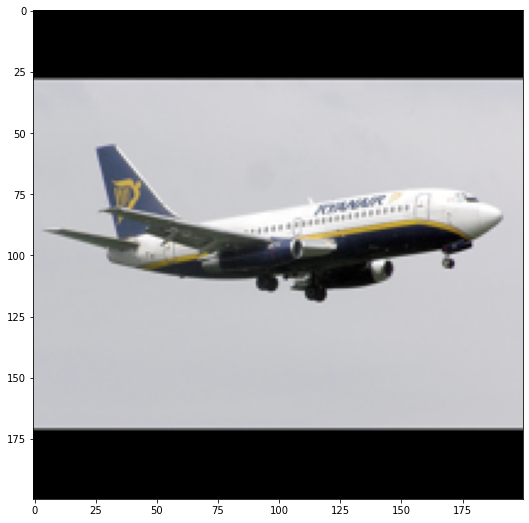

In [92]:
plt.imshow(image_data_1)

In [93]:
prediction = model_cnn.predict(np.array([image_data_1,image_data_2]))

In [94]:
predicted_classes = np.argmax(prediction,axis=1)
predicted_classes

array([3, 5])

In [95]:
print(label_encoder.inverse_transform ( predicted_classes ))

['Motorbikes' 'airplanes']
